# Generating virtual products


#### Install the environment (need DEA fc and wofs packages) using the following on command line

In [1]:
'''
python3 -m venv ~/venvs/VP_Environment
source ~/venvs/VP_Environment/bin/activate
deactivate
realpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth
source ~/venvs/VP_Environment/bin/activate
pip install --extra-index-url=https://packages.dea.ga.gov.au/ fc
pip install ephem
pip install --index-url https://packages.dea.ga.gov.au/ wofs
python -m ipykernel install --user --name=VP_Environment
cd venvs/VP_Environment
touch setup.py

##### add in text below to setup.py

from setuptools import setup, find_packages

setup(
    name='VP_Environment',
    version='1.0',
    packages=find_packages(),
    install_requires=[
        'ephem',
        'wofs',
        'fc'
    ],
)

#####

python setup.py bdist_egg

'''

"\npython3 -m venv ~/venvs/VP_Environment\nsource ~/venvs/VP_Environment/bin/activate\ndeactivate\nrealpath /env/lib/python3.10/site-packages > ~/venvs/VP_Environment/lib/python3.10/site-packages/base_venv.pth\nsource ~/venvs/VP_Environment/bin/activate\npip install --extra-index-url=https://packages.dea.ga.gov.au/ fc\npip install ephem\npip install --index-url https://packages.dea.ga.gov.au/ wofs\npython -m ipykernel install --user --name=VP_Environment\ncd venvs/VP_Environment\ntouch setup.py\n\n##### add in text below to setup.py\n\nfrom setuptools import setup, find_packages\n\nsetup(\n    name='VP_Environment',\n    version='1.0',\n    packages=find_packages(),\n    install_requires=[\n        'ephem',\n        'wofs',\n        'fc'\n    ],\n)\n\n#####\n\npython setup.py bdist_egg\n\n"

#### Load packages

In [2]:
%matplotlib inline
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import os, sys
sys.path.insert(1, "/home/jovyan/code/livingearth_png/le_plugins")
import datacube

from dea_tools.plotting import rgb, display_map
from datacube.utils.cog import write_cog
from datacube.drivers.netcdf import write_dataset_to_netcdf

# for virtual products
import yaml
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER

dc = datacube.Datacube(app='Virtual_products')

catalog = catalog_from_file('../le_plugins/virtual_product_cat.yaml')


#### AWS Access

In [3]:
## Optional: Access AWS "requester-pays" buckets
# This is necessary for Landsat ("landsatN_c2l2_*") and Sentinel-2 ("s2_l2a") products
from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=False, requester_pays=True)#, client=client);

#### display AOI

In [4]:
latitude = (-7.329, -7.339)
longitude = (144.44, 144.45)

# latitude = (-7.3, -7.4)
# longitude = (144.4, 144.5)
display_map(longitude, latitude)

#### Set query

In [5]:
time = ('2020-01-01', '2020-03-31')

crs = "EPSG:32755"
res = (30, -30)

query =({'time': time,
             'latitude':latitude,
            'longitude':longitude,
            'output_crs':crs,
            'resolution':res})

## Load virtual products

In [6]:
list(catalog)

['woody_cover_model',
 'ls_8',
 'geomedian',
 'fractional_cover',
 'DEM',
 'WOfS',
 'mangroves',
 'WCF']

### Landsat 8

In [ ]:
# Landsat 8
product = catalog['ls_8']
ls_8 = product.load(dc, **query)

In [ ]:
ls_8

### Geomedian

In [7]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "geomedian"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [8]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'geomedian': geomedian.geomedian}

In [9]:
# load geomedian
product = catalog['geomedian']
geomedian = product.load(dc, **query)

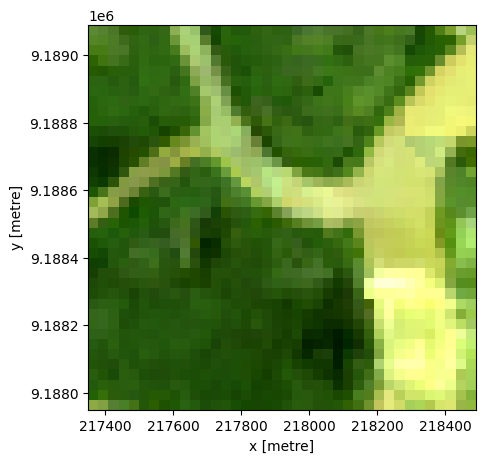

In [10]:
# Plot the result
rgb(geomedian, size=5)

### Fractional Cover

In [ ]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "fractional_cover"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [ ]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

In [ ]:
# load fractional cover
product = catalog['fractional_cover']
fractional_cover = product.load(dc, **query)

In [ ]:
fractional_cover.PV_PC_90.plot()

### WOfS

In [ ]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "WOfS"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [ ]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

In [ ]:
# load wofs
product = catalog['WOfS']
wofs = product.load(dc, **query)

In [ ]:
wofs.frequency.plot()

## WCF
- need to run geomedian above beforehand to then load WCF (which uses geomedian as input)

In [11]:
# Need to add any tranformations for the VP you're using

# Get location of transformation
transformation = "WCF"
trans_loc = importlib.import_module(transformation)
trans_class = transformation.split('.')[-1]

DEFAULT_RESOLVER.register('transform', trans_class, getattr(trans_loc, trans_class) )

In [12]:
# see what's already in the resolver 
DEFAULT_RESOLVER.lookup_table['transform']

{'make_mask': datacube.virtual.transformations.MakeMask,
 'apply_mask': datacube.virtual.transformations.ApplyMask,
 'to_float': datacube.virtual.transformations.ToFloat,
 'rename': datacube.virtual.transformations.Rename,
 'select': datacube.virtual.transformations.Select,
 'expressions': datacube.virtual.transformations.Expressions,
 'geomedian': geomedian.geomedian,
 'WCF': WCF.WCF}

In [13]:
# load WCF
product = catalog['WCF']
wcf = product.load(dc, **query)

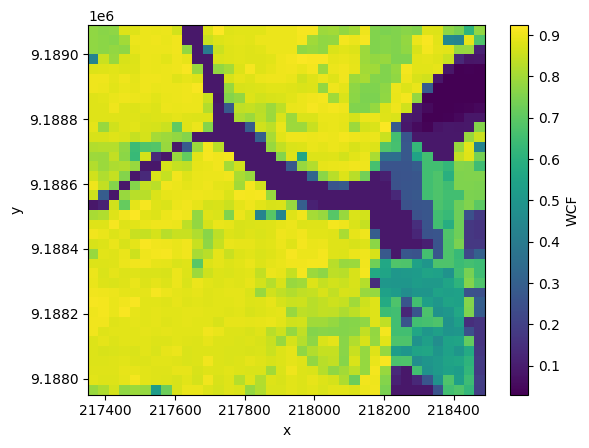

In [14]:
wcf.WCF.plot()

### Need outputs? - change below as required

In [ ]:
# # add crs and to_array for cog output
# geomedian.attrs['crs'] = 'EPSG:32755'
# geomedian_export = geomedian.to_array()

# # output as cog
# write_cog(geomedian_export, '../data/geomedian_test.tif', overwrite=True)

# # export out as .nc to allow load back in easily as xarray
# write_dataset_to_netcdf(geomedian, '../data/geomedian_test.nc')